<h1>Sampling Experimentation</h1>

First, the packages needed for the experiment are imported and relevant measures such as bounds and error for correlation are set.

In [1]:
#import packages and define the model to sample from
from math import sqrt
import statistics
from collections import deque
from numpy.random import Generator, PCG64
import random
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
font = {
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# LPS: I've un-hardcoded the maximum distance at which we sample data. 
# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
MaxDistance = 4000
e = 0.15 #error value
# LPS: I've un-hardcoded the true value as we might want to play with this later. 
ValueTRUE = 400
iterations = 1000 #the maximum no. of iterations for each sample
UpperBound = MaxDistance#4000
reps = 1000 #how many times to repeat the whole experiment
stdSC = 17 #stopping criterion value for standard deviation
rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting

isSCstd = False
isSCdhat = True
triplesc = True #s.c. ->  iterations > 10, sd < 25, |dhat - prev dhat | < 3 for 3 iters
scdiff = 3 #absolute difference for Dhat for stopping criteria

/Users/mustafamajid/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


<h2>Generating Noisy Artificial Data</h2>

In [2]:
#np.#random.seed(8)
dictsize = 100               

my_dict = {key: 0 for key in range(0, UpperBound+1)} #keep track of how many times a value was accessed; reset before each algorithm run

def getNoise(d):
    d = round(d) #round to the nearest integer
    count = my_dict[d]
    my_dict[d] += 1 #noise for d value accessed once; increment counter to get different noise
    if(my_dict[d] == dictsize):

        print("dict limit reached for value: ",d)
        my_dict[d] = 0 #cycle back to avoid going out of bounds
    return error_arrays[count][d]

error_arrays = []
for i in range(0,dictsize):
    rng = Generator(PCG64(seed=i))
    error_array = rng.normal(loc = 0, scale = e, size = 4001) #normal dist. centred around 0 with st.dev. e 
    error_arrays.append(error_array)


#function to calculate correlation (rho) for distance to cell, d, and correlation distance, D
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)

#generate correlation value using the function above, with corr. distance fixed  (D=400km). Distance to grid cell, d, is the input parameter. 
def generate_value(d,err): 
    rho = cordist(d,ValueTRUE) #We know that the true value of D is 400km
    noisyrho = rho + getNoise(d)  #add random error to rho, taken from a normal distribution with mean = 0 and standard deviation = e
    return(noisyrho) #returns the resulting noisy correlation value


    

<h2>Test Noise</h2>

In [3]:
my_dict = {key: 0 for key in range(0, UpperBound+1)}
print(getNoise(300))
print(getNoise(300))
print(getNoise(300))
my_dict = {key: 0 for key in range(0, UpperBound+1)}
print(getNoise(300))

0.18048884311747468
-0.08891617915712234
0.23742084180381995
0.18048884311747468


<h2>Random Point Generation</h2>

D-hat estimate:  [356.62352143]
covariance:  [[1237.09900198]]
63.69616873214543
26.97867137638703


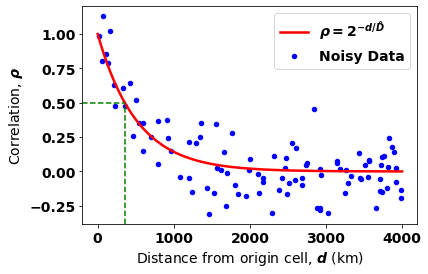

In [72]:

#np.#random.seed(8)
my_dict = {key: 0 for key in range(0, UpperBound+1)} #keep track of how many times a value was accessed
#a function that generates n random samples, with distance values of a given range
def generate_random_samples(n,lower_bound,upper_bound,err): 
    rng = Generator(PCG64(seed=0))
    x = []
    y = []
    for i in range(n): 
        d= rng.uniform(low=lower_bound,high=upper_bound,size=1)[0] #generate random distance value from fixed cell as a sample from a uniform distribution, in the range L.B. to U.B.
        rho_noisy = generate_value(d,err)
        
        x.append(d)
        y.append(rho_noisy)
    return (x,y)

#Generate scatter plot of distance vs correlation, with random colors to help differentiate overlapping points. 
m = 100 #number of samples
x,y = generate_random_samples(m,0,MaxDistance,e) #pass distance bounds and st. error
plt.figure(0)
plt.scatter(x,y, c='blue', s=20, label = "Noisy Data") 

plt.xlabel("Distance from origin cell, $d$ (km)")
plt.ylabel(r'Correlation, $\rho$')
#plt.title("Scatter plot of generated distance and correlation values")

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit curve with generated data and initial guess for parameter as 400km

print("D-hat estimate: ", params) #this prints the value of b (corr. distance) estimated from the curve fit on the generated data
print("covariance: ", covs)

#Plot the fitted curve by calculating y values based on rho without noise
axis_d = np.array(range(MaxDistance)) #prepare the axis for the fitted line
yfit = 2**(-axis_d/params[0]) #use the estimated D-hat for the fitted line
l_strg = r"$\rho = 2^{-d/\hat{D}}$"
plt.plot(axis_d, yfit, c='red',linewidth='2.5', label = l_strg)


plt.axvline(x=params[0], color='g', linestyle='--', ymax = 0.55)

plt.axhline(y=0.5, linestyle='--', color='green', xmax=params[0]/2800)

plt.legend()




rng = Generator(PCG64(seed=0))
print(rng.uniform(low=0,high=100,size=1)[0])
print(rng.uniform(low=0,high=100,size=1)[0])

plt.savefig('egspread.pdf',format='pdf',bbox_inches='tight')

<h2>Adjusted Binary Search With Randomness</h2>

In [41]:
#np.#random.seed(8)

#Holds list of values for each repetition
Dhat_arr2_lst = [  ]
cov_arr2_lst = [  ]
x2_lst = [  ]
y2_lst = [  ]

stop_i = []
stop_Dhat = []
xaxes = []
samsize = []
Diffatstop = []


my_dict = {key: 0 for key in range(0, UpperBound+1)}
overflowcount = 0

#Repeat the whole algorithm a certain number of repetitions. Generate a new set of noise grids for each repetition, using the repetition number as the randomness seed.
for a in range(0,reps):
    my_dict = {key: 0 for key in range(0, UpperBound+1)}
    rng = Generator(PCG64(seed=a))
    rp0 = rng.uniform(100, 1000) #sample initial random guess of D-hat for curve fitting
    error_arrays = []
    for i in range(0,dictsize):

        #error_array = np.random.normal(0, e, size=4001) 
        error_array = rng.normal(loc = 0, scale = e, size = 4001) #normal dist. centred around 0 with st.dev. e 
        error_arrays.append(error_array)

    startcount = 1
    maxcount = 3


    q1,q3,q1_rho,q3_rho,m1,m1_rho,mid_Dhat = 0,0,0,0,0,0,0 #reset all values
    rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting
    
    Dhat_arr2 = [  ]
    cov_arr2 = [  ]
    x2 = [  ]
    y2 = [  ]

    


    p_low = generate_value(LowerBound,e) #generate values for rho for distances 100km and 1000km using the neg. exp. model (again, with noise)
    p_upper = generate_value(UpperBound,e)

    x2 = [LowerBound,UpperBound]
    y2 = [p_low,p_upper] #store distance and rho values in lists for easy plotting


    params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


    Dhat_arr2.append(params[0]) #Dhat_arr[0] becomes our first estimate for correlation distance
    cov_arr2.append(sqrt(covs[0][0])) #we also store covariance to plot later
    #Now take the mean:

    m1 = (LowerBound+Dhat_arr2[0]) * 0.5
    m2 = (UpperBound+Dhat_arr2[0]) * 0.5

    #Calculate correlation for each new distance value and fit curve on these two + previous two points:

    m1_rho = generate_value(m1,e)
    m2_rho = generate_value(m2,e)

    x2.append(m1)
    y2.append(m1_rho)
    x2.append(m2)
    y2.append(m2_rho)

    params, covs = optimize.curve_fit(cordist, xdata = x2, ydata = y2, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates

    Dhat_arr2.append(params[0]) #new estimate of correlation distance, D-hat
    cov_arr2.append(sqrt(covs[0][0]))

    i_arr = [0,1]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.

    for i in range(1,iterations):
        i_arr.append(i+1) #update every iteration
        randrange = (UpperBound - LowerBound)/4 #how much randomness to inject

        mid_Dhat = 0.5 * (Dhat_arr2[i] + Dhat_arr2[i-1])
        mid_Dhat = (Dhat_arr2[i]+Dhat_arr2[i-1])*0.5 + np.random.normal(0, randrange, size=1)[0] #rng.normal(loc = 0, scale = randrange, size = 1)[0]
        while(mid_Dhat > MaxDistance or mid_Dhat < LowerBound):
            mid_Dhat = (Dhat_arr2[i]+Dhat_arr2[i-1])*0.5 + np.random.normal(0, randrange, size=1)[0]


        rho_mid_Dhat = generate_value(mid_Dhat,e)
        x2.append(mid_Dhat)
        y2.append(rho_mid_Dhat)
        
        if Dhat_arr2[i] < Dhat_arr2[i-1]: #take two distances between Dhat[i] and 100. We used mean for one distance, but for two we will use 1st and 3rd quartile.
            q1 = (Dhat_arr2[i]+LowerBound)*0.25 + np.random.normal(0, randrange, size=1)[0]
            while(q1 > MaxDistance or q1 < LowerBound):
                q1 = (Dhat_arr2[i]+LowerBound)*0.25 + np.random.normal(0, randrange, size=1)[0]
            q1_rho = generate_value(q1,e) 

            q3 = (Dhat_arr2[i]+LowerBound)*0.75 + np.random.normal(0, randrange, size=1)[0]
            while(q3 > MaxDistance or q3 < LowerBound):
                q3 = (Dhat_arr2[i]+LowerBound)*0.75 + np.random.normal(0, randrange, size=1)[0]
            q3_rho = generate_value(q3,e)
            
            #take one point between Dhat[i] and 1000. We can use mean for a single point.
            m1 = (Dhat_arr2[i]+UpperBound)*0.5 + np.random.normal(0, randrange, size=1)[0]
            while(m1 > MaxDistance or m1 < LowerBound):
                m1 = (Dhat_arr2[i]+UpperBound)*0.5 + np.random.normal(0, randrange, size=1)[0]
            m1_rho = generate_value(m1,e)

        else: #vice versa; take quartiles between Dhat[i] and 1000, and median between Dhat[i] and 100.

            q1 = (Dhat_arr2[i]+UpperBound)*0.25 + np.random.normal(0, randrange, size=1)[0]
            while(q1 > MaxDistance or q1 < LowerBound):
                q1 = (Dhat_arr2[i]+UpperBound)*0.25 + np.random.normal(0, randrange, size=1)[0]
            q1_rho = generate_value(q1,e)
            q3 = (Dhat_arr2[i]+UpperBound)*0.75 + np.random.normal(0, randrange, size=1)[0]
            while(q3 > MaxDistance or q3 < LowerBound):
                q3 = (Dhat_arr2[i]+UpperBound)*0.75 + np.random.normal(0, randrange, size=1)[0]
            
            q3_rho = generate_value(q3,e)


            m1 = (Dhat_arr2[i]+LowerBound) * 0.5 + np.random.normal(0, randrange, size=1)[0]
            while(m1 > MaxDistance or m1 < LowerBound):
                m1 = (Dhat_arr2[i]+LowerBound) * 0.5 + np.random.normal(0, randrange, size=1)[0]
            m1_rho = generate_value(m1,e)
        
        x2.append(q1)        #append all distance-correlation pairs to the correct x and y lists
        y2.append(q1_rho)
        x2.append(q3)
        y2.append(q3_rho)
        x2.append(m1)
        y2.append(m1_rho)


        params, covs = optimize.curve_fit(cordist, xdata = x2, ydata = y2, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
        Dhat_arr2.append(params[0]) #new estimate of corr. dist added to D-hat list
        cov_arr2.append(np.sqrt(covs[0][0]))

        #Stopping criteria st. dev.
        if(np.sqrt(covs[0][0]) < stdSC and isSCstd):
            print("std. dev stopping reached")
            diff = params[0] - ValueTRUE
            Diffatstop.append(diff)
            stop_i.append(i) #record which iteration no. the SC occurs 
            stop_Dhat.append(i)
            xaxes.append(i_arr)
            samsize.append(len(x2)) #size of sample set at stop
            break #end this rep. of the algorithm in this case

         #if |Dhat - D| < 3km for 3 iters, stop the run
        if(i > 10 ):
            absdiff = abs(params[0] - Dhat_arr2[-2]) #estimate difference between current and previous iteration
            if (absdiff < scdiff):
                startcount+=1
            else:
                startcount = 0

            if (startcount >= maxcount and cov_arr2[-1]<25): #triple s.c. -> past 10 iterations, if |Dhat - prev Dhat| < 3km for at least 3 iters, and s.d. < 25km, then stop
                diff = params[0] - ValueTRUE
                Diffatstop.append(diff)
                stop_i.append(i) #record which iteration no. the SC occurs 
                stop_Dhat.append(i)
                xaxes.append(i_arr)
                samsize.append(len(x2)) #size of sample set at stop
                break #end this rep. of the algorithm in this case


        

     

    
    Dhat_arr2_lst.append(Dhat_arr2)
    cov_arr2_lst.append(cov_arr2)
    x2_lst.append(x2)
    y2_lst.append(y2)



print(len(stop_i))
print(len(stop_Dhat))

<ipython-input-38-5dd2c28a7939>:25: RuntimeWarning: overflow encountered in power
  rho = 2**(-d/D)


1000
1000


In [42]:
print(stop_i)

[29, 36, 22, 32, 20, 38, 34, 19, 26, 34, 38, 33, 40, 23, 50, 32, 39, 37, 34, 39, 38, 32, 24, 42, 23, 37, 32, 33, 22, 23, 27, 42, 35, 28, 40, 28, 40, 50, 24, 32, 21, 36, 24, 26, 24, 38, 30, 29, 32, 24, 34, 22, 35, 44, 25, 34, 35, 31, 33, 38, 42, 30, 22, 38, 37, 27, 26, 35, 38, 30, 33, 18, 35, 41, 32, 36, 38, 24, 35, 25, 27, 29, 33, 40, 36, 27, 46, 31, 27, 27, 35, 26, 29, 40, 36, 38, 31, 27, 47, 28, 23, 31, 26, 29, 31, 32, 36, 24, 41, 27, 47, 49, 34, 38, 36, 30, 37, 29, 28, 41, 36, 30, 29, 30, 33, 16, 44, 29, 25, 29, 31, 38, 25, 27, 24, 29, 30, 28, 41, 24, 34, 30, 34, 33, 23, 29, 24, 30, 38, 26, 42, 37, 35, 26, 44, 48, 34, 30, 22, 36, 30, 43, 44, 26, 43, 42, 17, 33, 31, 30, 39, 38, 31, 40, 41, 27, 14, 37, 44, 24, 21, 28, 36, 23, 42, 46, 29, 46, 29, 38, 32, 35, 34, 23, 19, 35, 32, 35, 35, 43, 48, 34, 29, 25, 42, 25, 23, 35, 30, 27, 40, 24, 31, 32, 30, 29, 29, 25, 29, 26, 24, 28, 30, 30, 39, 34, 29, 23, 25, 26, 32, 37, 27, 27, 27, 41, 36, 32, 32, 31, 36, 35, 31, 26, 26, 38, 34, 28, 26, 23,

In [43]:
print(len(Dhat_arr2_lst[0]))

31


<h2>Plotting</h2>

p0 value: 570.0327305231164
error value: 0.15
7.002052270584675
plots/abs/triple3_0_15__1000/7_002052270584675.pdf
28.0082090823387
21.890950384981604


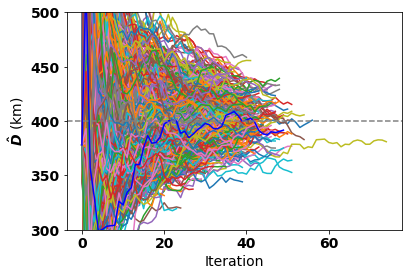

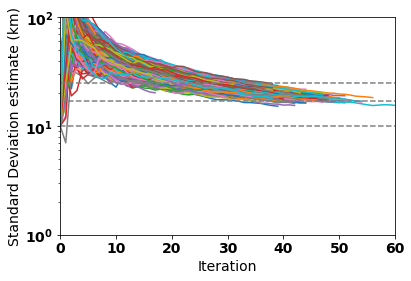

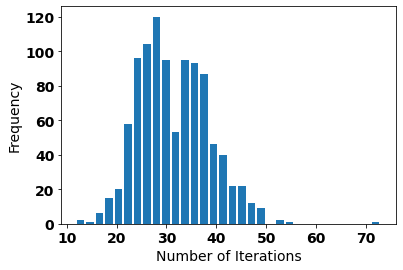

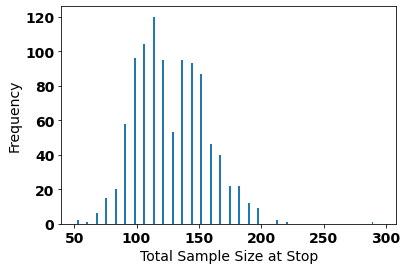

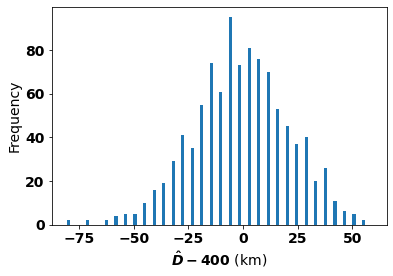

In [44]:
print("p0 value:",rp0)
print("error value:",e)




plt.figure(8)
for i in range(0,len(Dhat_arr2_lst)): 
    #new_iarr = list(range(0, len(Dhat_arr2_lst[i])))
    i_arr = list(range(0, len(Dhat_arr2_lst[i])))

    if(i == len(Dhat_arr2_lst)-1):
        plt.plot(i_arr,Dhat_arr2_lst[i], label = 'V2',alpha=1,color='blue')
    elif(i == 0):
        plt.plot(i_arr,Dhat_arr2_lst[0], label = 'V2',alpha=1,color='red') #v2
    else:
        plt.plot(i_arr,Dhat_arr2_lst[i], label = 'V2',alpha=1)#,color='gray') #v2  
plt.axhline(y=ValueTRUE, color='gray', linestyle='--')
plt.ylim([300,500])
plt.ylabel('$\hat{D}$ (km)')
plt.xlabel('Iteration')  

#list(range(0, len(Dhat_min)))


#Plot median of st. dev. at each iteration
plt.figure(60)
for i in range(0,len(cov_arr2_lst)):
     i_arr = list(range(0, len(Dhat_arr2_lst[i])))
     plt.plot(i_arr,cov_arr2_lst[i], label = 'V2',alpha=1)

plt.axhline(y=(10), color='gray', linestyle='--')
plt.axhline(y=(25), color='gray', linestyle='--')
plt.axhline(y=(17), color='gray', linestyle='--')

plt.yscale('log')
plt.ylim([1,10**2])
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
plt.xlim(0,60)


#SET FOLDER PATH 
import os
folder_path = "plots/abs/triple"
folder_path += str(scdiff)
folder_path = folder_path + "_" + (str(e)).replace('.','_') + '__' + str(reps) + '/' #make separate folders based on noise value of synthetic data

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.figure(61)
indices = list(range(len(stop_i)))

plt.hist(stop_i, bins=round(np.sqrt(len(stop_i))), width = 1.5)
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
std = np.std(stop_i)
print(std)

name = folder_path + (str(std)).replace('.','_') + ('.pdf')
print(name)
plt.savefig(name)
#plt.text(0.05, -0.15, f"Standard deviation: {std:.2f}", transform=plt.gca().transAxes)
#fit normal curve to the data and figure out the standard deviation of this list.

plt.figure(62)
indices = list(range(len(samsize)))

plt.hist(samsize, bins=round(np.sqrt(len(samsize))), width = 1.5)
plt.xlabel('Total Sample Size at Stop')
plt.ylabel('Frequency')
std = np.std(samsize)
print(std)
name = folder_path + (str(std)).replace('.','_') + ('.pdf')
plt.savefig(name)

plt.figure(63)
indices = list(range(len(samsize)))

plt.hist(Diffatstop, bins=round(np.sqrt(len(Diffatstop))), width = 1.5)
plt.xlabel('$\hat{D}-400$ (km)')
plt.ylabel('Frequency')
std = np.std(Diffatstop)
print(std)
name = folder_path + (str(std)).replace('.','_') + ('.pdf')
plt.savefig(name)




No handles with labels found to put in legend.


total no. of samples for ADS 196


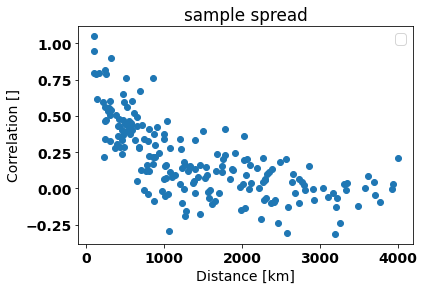

In [45]:


#I made one for V2 as well
plt.figure(7)
plt.title("sample spread")
plt.scatter(x2,y2)
#plt.plot(np.arange(4000), cordist(np.arange(4000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  
plt.legend(loc="upper right")


print("total no. of samples for ADS",len(x2))

In [46]:

import pickle
import os

folder_path = "results_/ABS_stopping/results_ABS_triple"
folder_path += str(scdiff)
folder_path = folder_path + "_" + (str(e)).replace('.','_') + '__' + str(reps) #make separate folders based on noise value of synthetic data


if not os.path.exists(folder_path):
    os.makedirs(folder_path)

file_path = os.path.join(folder_path, "xaxes.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(xaxes, f)

file_path = os.path.join(folder_path, "stop_i.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(stop_i, f)

file_path = os.path.join(folder_path, "samsize.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(samsize, f)

file_path = os.path.join(folder_path, "DiffAtStop.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Diffatstop, f)

file_path = os.path.join(folder_path, "cov_arr2_lst.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(cov_arr2_lst, f)

plt.figure(23)
indices = list(range(len(diffat100)))

plt.hist(diffat100, bins=round(np.sqrt(len(diffat100))), width = 1.5)
plt.xlabel('$\hat{D}-400$(km)')
plt.ylabel('Frequency')
std = np.std(diffat100)
print(std)
name = 'plots/Hist100_ABS' + (str(std)).replace('.','_') + ('.pdf')
plt.savefig(name)
#plt.text(0.05, -0.15, f"Standard deviation: {std:.2f}", transform=plt.gca().transAxes)
#fit normal curve to the data and figure out the standard deviation of this list.


draw hist

scatters!

Dhat range[-63.324910574138414, 75.43313110138547]
range size =  138.75804167552388
[[ 1.         -0.14718803]
 [-0.14718803  1.        ]]


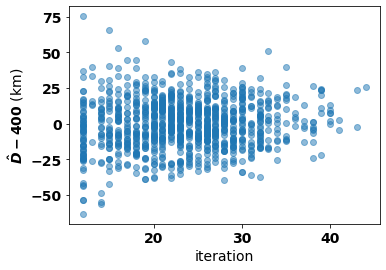

In [66]:
folder_path = "results_/U_stopping/results_U_triple3_0_15__1000"

file_path = os.path.join(folder_path, "stop_i.pkl")

with open(file_path, 'rb') as f:
    nstop_i = pickle.load(f)


file_path = os.path.join(folder_path, "DiffAtStop.pkl")


with open(file_path, 'rb') as f:
    nDiffAtStop = pickle.load(f)


plt.scatter(nstop_i, (nDiffAtStop), alpha = 0.5)


plt.xlabel('iteration')
plt.ylabel('$\hat{D} - 400$ (km)')


print("Dhat range[{}, {}]".format(min(nDiffAtStop), max(nDiffAtStop)))
print("range size = ",max(nDiffAtStop) - min(nDiffAtStop))

corrc = np.corrcoef(nstop_i,np.abs(nDiffAtStop))
print(corrc)
plt.subplots_adjust(left=0.18)
plt.savefig('plots/scatters/Utriple_' + str(corrc[0][1]) + '.pdf')


show scatter plot for std < 25, to show that fewer than 10 iterations shows many outliers.(add to notes)

based on the above, 20 iters might be better choice; also based on this, reduce s.d. to 17 (generate plots for abs or u).

